In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap

from src.maze_generator import get_maze_mdp, create_mdp
from src.policies import EpsGreedyPolicy, SoftmaxPolicy
from src.learning import QLearning, VI_Q
from src.utils import get_one_episode, plot_errors, plot_maze_path_q
from src.utils import plot_q, viz_path, plot_maze

In [3]:
SEED = 0
np.random.seed(SEED)

## Generate Maze

Best path length: 43


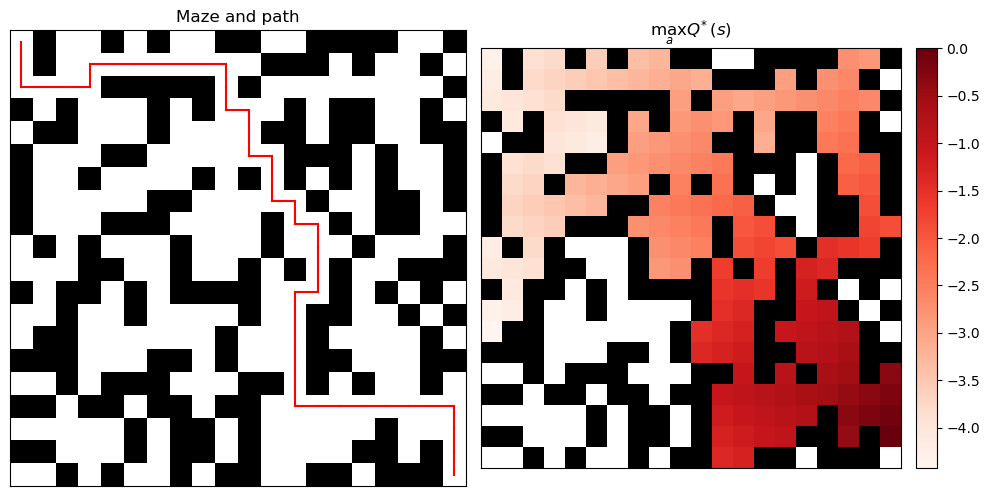

In [4]:
maze_name = "random large"
ALPHA = .6

if "random" in maze_name:
    if maze_name == "random small":
        nrows = 8
        ncols = 12
        p = .5
    elif maze_name == "random large":
        nrows = 20
        ncols = 20
        p = .4
    mdp, grid, qstar = get_maze_mdp(nrows, ncols, p, gamma=.9, seed=SEED)
elif "custom" in maze_name:
    if maze_name == "custom small":
        maze = np.load("custom_mazes/maze_14_14.npy")
    elif maze_name == "custom large":
        maze = np.load("custom_mazes/maze_29_29.npy")
    elif maze_name == "custom large bis":
        maze = np.load("custom_mazes/maze_29_29_bis.npy")
    else:
        raise ValueError("Unknown custom maze name")
    walls_ixs = np.where(maze.ravel() == 0)[0]
    mdp, grid = create_mdp(walls_ixs, *maze.shape, gamma=0.9)
    qstar, _ = VI_Q(mdp, eps=1e-8)
else:
    raise ValueError("Unknown maze name")

_, best_t, best_path = get_one_episode(mdp, qstar)

if "small" in maze_name:
    mdp.horizon = 1000
    NB_ITER = int(1e6)
elif "large" in maze_name:
    mdp.horizon = 10000
    NB_ITER = int(1e7)
else:
    raise ValueError("Unknown maze name")
PATIENCE = NB_ITER//20

print("Best path length: {}".format(best_t))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot_maze_path_q(grid, qstar, best_path, axes=(ax1, ax2))
fig.tight_layout()

## Experiments

- Compare eps-greedy policy and softmax behaviour policy.
- Compare different values of the exploration parameters (epsilon for eps-greedy and tau for softmax).
- Compare different learning rates.
- Compare different sizes and difficluties of Maze MDPs.
- Check that your learned Q functions make sense.

### Different sizes and difficulties

In [5]:
pol_eps = EpsGreedyPolicy(mdp, epsilon=.9).get_action
qhat_eps, list_errors_eps = QLearning(mdp, pol_eps, qstar, best_t, patience=PATIENCE, alpha=ALPHA, nb_iter=NB_ITER)
_, t_eps, path_eps = get_one_episode(mdp, qhat_eps)

Start Q learning with EpsGreedyPolicy


  5%|████▍                                                                                  | 510041/10000000 [00:12<03:57, 39879.30it/s, min path=43]


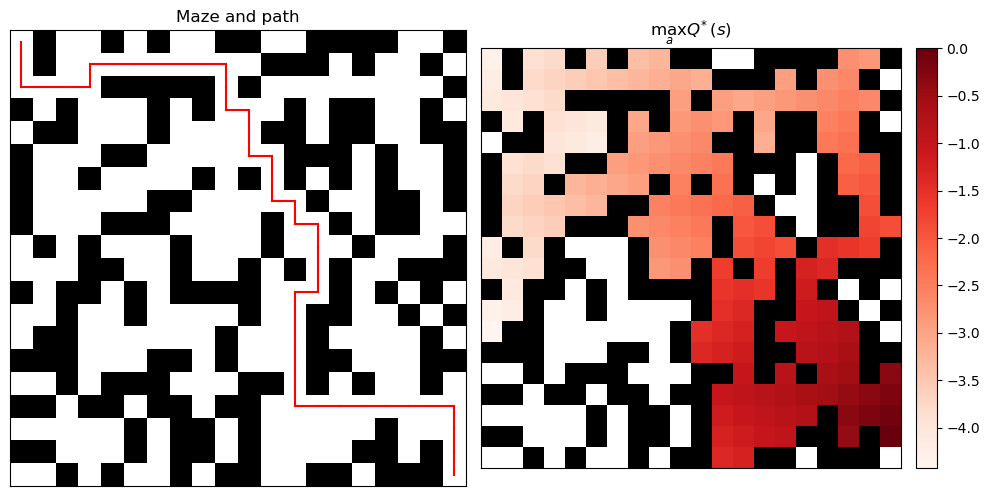

In [6]:
plot_maze_path_q(grid, qhat_eps, path_eps)
plt.tight_layout()

In [7]:
pol_soft = SoftmaxPolicy(mdp, tau=.9).get_action
qhat_soft, list_errors_soft = QLearning(mdp, pol_soft, qstar, best_t, patience=PATIENCE, alpha=ALPHA, nb_iter=NB_ITER)
_, t_soft, path_soft = get_one_episode(mdp, qhat_soft)

Start Q learning with SoftmaxPolicy


  6%|████▉                                                                                  | 570337/10000000 [00:20<05:38, 27821.75it/s, min path=43]


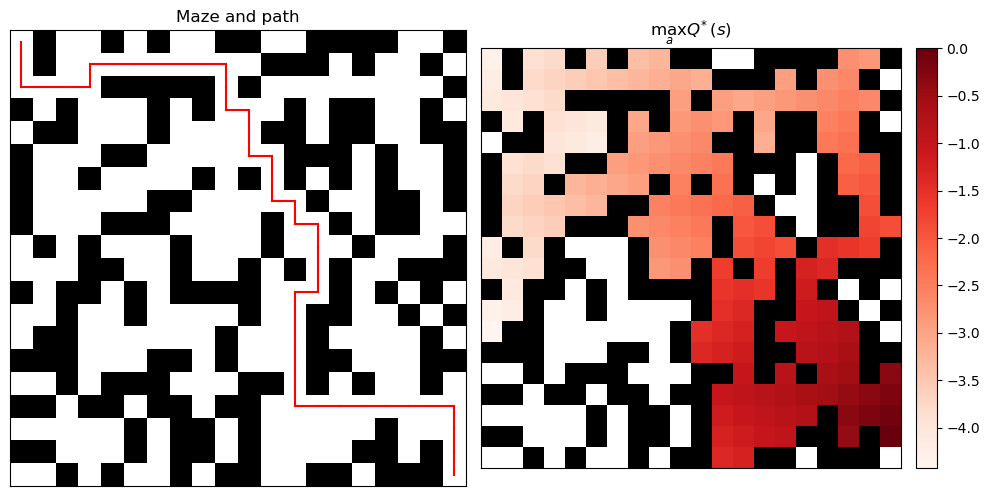

In [8]:
plot_maze_path_q(grid, qhat_soft, path_soft)
plt.tight_layout()

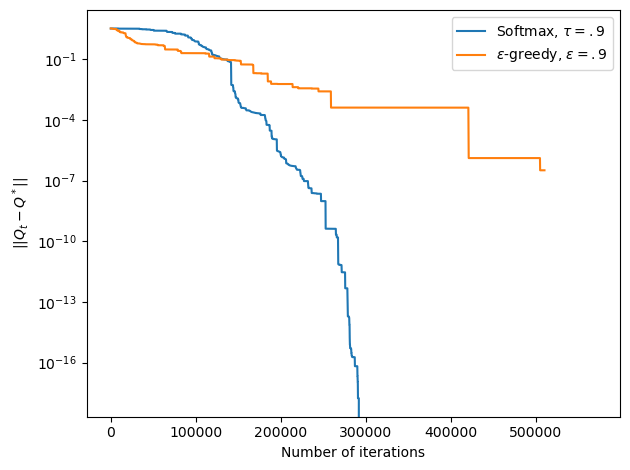

In [9]:
plot_errors({r"Softmax, $\tau = .9$": list_errors_soft, r"$\epsilon$-greedy, $\epsilon = .9$": list_errors_eps})
plt.tight_layout()